# Тетрадь 6: Алгоритм k-ближайших соседей

## Содержание

- [Введение](#Ввдение)
- [Код и примеры](#Код-и-примеры)
- [Задания](#Задания)

***

## Введение

Алгоритм k-ближайших соседей KNN — это один из самых простых и интуитивно понятных алгоритмов классификации. Он относится к
методам **ленивого обучения** (lazy learning), так как не строит модель на этапе обучения, а
откладывает все вычисления до момента классификации нового объекта.

#### Основные шаги алгоритма

1. **Выбор числа соседей (k)**
   - Параметр k определяет, сколько ближайших соседей будет учитываться при классификации.
   - Обычно выбирается нечётное число, чтобы избежать ничьей при голосовании.

2. **Вычисление расстояний**
   - Для нового объекта вычисляются расстояния до всех объектов в обучающей выборке.
   - Часто используются метрики расстояния, такие как евклидово расстояние, манхэттенское расстояние
   или косинусное сходство.

3. **Выбор k ближайших соседей**
   - Из обучающей выборки выбираются $k$ объектов, которые находятся ближе всего к новому объекту.

4. **Голосование**
   - Класс нового объекта определяется путём голосования среди $k$ ближайших соседей.
   - Например, если $k=3$, и два соседа принадлежат к классу $A$, а один — к классу $B$, то новый
   объект будет отнесён к классу $A$.

5. **Возвращение результата**:
   - Алгоритм возвращает предсказанный класс для нового объекта.

#### Преимущества:

- Простота реализации и интерпретации.
- Не требует этапа обучения (все вычисления происходят на этапе предсказания).
- Хорошо работает на данных с небольшим количеством признаков.

#### Недостатки:

- Вычислительная сложность на больших данных, так как для каждого нового объекта нужно вычислять
расстояния до всех объектов в обучающей выборке.
- Чувствительность к масштабированию данных (необходимо нормализовать признаки).
- Чувствительность к выбору параметра $k$: слишком маленькое $k$ может привести к переобучению, а
слишком большое — к недообучению.

***

## Код и примеры

In [11]:
from typing import Dict, Optional
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import ndarray
from scipy.stats import mode

from modules.metrics import compute_confusion_matrix
from modules.models import ModelBase
from modules.preprocessing import DataSplitter
from modules.visuals import plot_confusion_matrix


def unzip(file_path: str, extract_to: str) -> None:
    with ZipFile(file_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)

### KNN в два цикла

Ниже определён класс, выполняющий функции алгоритма k-ближайших соседей. Он в состоянии решать
несложные задачи классификации, и ниже мы в этом убедимся. Прежде чем двигаться дальше,
ознакомьтесь с подробными комментариями в теле класса, они помогут лучше понять принцип работы
алгоритма.

In [2]:
class LoopingKNNClassifier(ModelBase):
    # This K-Nearest Neighbors Classifier loops twice, comparing each train and
    # test point in the set. Uses Euclidean distance to determine the nearest
    # neighbors.

    def __init__(self):
        super().__init__()

    def fit(self, x_train: ndarray, y_train: ndarray, *args, **kwargs) -> None:
        super().fit(x_train, y_train, *args, **kwargs)

    def predict(self, x_test, n_neighbors: int = 5):
        # This method is where the distances calculation happens.
        n_test_samples = x_test.shape[0]
        n_train_samples = self.x_train.shape[0]
        distances = np.zeros((n_test_samples, n_train_samples))

        # Iterating over each test sample,
        for i in range(n_test_samples):
            # iterate over each training sample,
            for j in range(n_train_samples):
                # calculate the Euclidean distance between the current test
                # sample (`x_test[i]`) and the current training sample
                # (`x_train[j]`).
                distances[i, j] = np.sqrt(
                    np.sum(np.square(x_test[i, :] - self.x_train[j, :]))
                )

        # Predict the lables based on the distances calculated.
        predicted_labels = self._predict_labels(distances, n_neighbors)
        return predicted_labels

    def _predict_labels(
        self,
        distances: ndarray,
        n_neighbors: int = 5,
    ) -> ndarray:
        # Predicting labels is a separate process. That's why it has it's own
        # private method.
        n_test_samples = distances.shape[0]
        y_predicted = np.zeros((n_test_samples, 1))

        # Iterating over each test sample to predict its label,
        for i in range(n_test_samples):
            # sort the distances for the current test sample and get the
            # indices of the sorted distances,
            sorted_indices = np.argsort(distances[i, :])
            # determine the number of neighbors to consider, ensuring it does
            # not exceed the available neighbors,
            farthest_neighbor = np.min([n_neighbors, len(sorted_indices)])
            # get the labels of the closest neighbors from the training set,
            closest_neighbors = self.y_train[
                sorted_indices[:farthest_neighbor]
            ]
            # use the mode (most frequent label) of the closest neighbors as
            # the predicted label.
            y_predicted[i] = mode(closest_neighbors)[0]
        return y_predicted

Сейчас мы рассмотрим, насколько успешно описанный выше класс справится с классификацией цифр из
классического датасета MNIST.

Распакем архив с данными и разделим их на обучающую и тестовую выборки.

In [8]:
unzip("datasets/mnist.zip", "datasets")

mnist = pd.read_csv("datasets/mnist.zip")

Однако сейчас мы не будем использовать весь набор данных, так как вложенные циклы могут заставить
нас ждать вечность, пока модель обучится. Выделим первые 7000 точек данных и посмотрим, как наш
классификатор с ними.

In [78]:
mnist_7k = mnist.iloc[:7000, :]
splitter = DataSplitter(permute=True)
x_train, x_test, y_train, y_test = splitter.split_data(
    mnist_7k.drop(columns=["label"]).to_numpy(),
    mnist_7k["label"].to_numpy().reshape((-1, 1)),
    test_size=0.33,
)

Обучим `LoopingKNNClassifier` и вычислим матрицу ошибок

In [79]:
classifier = LoopingKNNClassifier()

classifier.fit(x_train, y_train)

y_predicted = classifier.predict(x_test)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

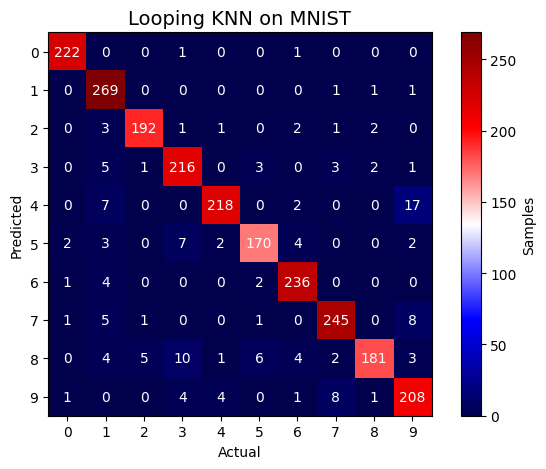

In [80]:
plot_confusion_matrix(confusion_matrix, "Looping KNN on MNIST")

Можете так же выполнить следующую ячейку сколько угодно раз, чтобы найти цифру, не соответсвующую
присвоенному классу.

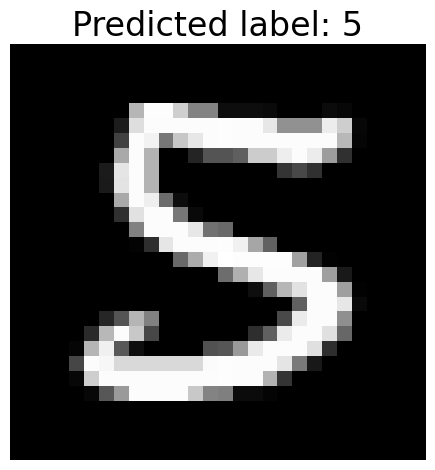

In [85]:
images_and_predictions = np.concatenate([y_predicted, x_test], axis=1)
index = np.random.randint(0, len(x_test))
image, label = (
    images_and_predictions[index, 1:].reshape((28, 28)),
    images_and_predictions[index, 0],
)

plt.axis("off")
plt.title(f"Predicted label: {int(label)}", fontsize=24)
plt.tight_layout()
plt.imshow(image, cmap="grey")

***

## Задания

### Задание 1

Несмотря на то, что `LoopingKNNClassifier` относительно неплохо справляется со совей задачей, его
главная проблема — в теле функции `predict()`. Там целых два вложенных цикла, которые обрабатывают
тысячи точек данных. Этот процесс занимает довольно много времени в силу природы языка Python.

Ваша задача — переработать метод `predict()` так, чтобы максимизировать использование функций из
библиотеки NumPy. Таким образом, скорость вычисления дистанций значительно возрастёт за счёт
векторных операций.

In [6]:
class OptimizedKNNClassifier(LoopingKNNClassifier):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x_train, y_train, *args, **kwargs) -> None:
        return super().fit(x_train, y_train, *args, **kwargs)

    def predict(self, x_test, n_neighbors = 5) -> ndarray:
        # This method should be calculating distances without any direct
        # looping. Use only NumPy vectorized operations.
        train_sum = ...
        test_sum = ...
        distances = ...

        predicted_labels = super()._predict_labels(distances, n_neighbors)
        return predicted_labels

После реализации более оптимизированного алгоритма выполните следующие ячейки для проверки.

In [ ]:
classifier = OptimizedKNNClassifier()

classifier.fit(x_train, y_train)

y_predicted = classifier.predict(x_test)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

In [ ]:
plot_confusion_matrix(confusion_matrix, "Looping KNN on MNIST")

### Задание 2

В качестве расширения для оптимизированной версии классификатора реализуйте механизм взвешивания
соседей так, чтобы каждому из ближайших соседей можно было присвоить некоторый мультипликатор для
увеличения его значимости.

In [7]:
class WeighingKNNClassifier(OptimizedKNNClassifier):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, x_train, y_train, *args, **kwargs) -> None:
        return super().fit(x_train, y_train, *args, **kwargs)

    def predict(
        self,
        x_test,
        n_neighbors=5,
        *,
        weight_map: Optional[Dict[int, int]] = None,
    ) -> ndarray:
        n_test_samples = x_test.shape[0]
        n_train_samples = self.x_train.shape[0]
        distances = np.zeros((n_test_samples, n_train_samples))

        for i in range(n_test_samples):
            for j in range(n_train_samples):
                distances[i, j] = np.sqrt(
                    np.sum(np.square(x_test[i, :] - self.x_train[j, :]))
                )

        predicted_labels = self._predict_labels(
            distances, n_neighbors, weight_map=weight_map
        )
        return predicted_labels

    def _predict_labels(
        self,
        distances: ndarray,
        n_neighbors: int = 5,
        *,
        weight_map: Optional[Dict[int, int]] = None,
    ) -> ndarray:
        n_test_samples = distances.shape[0]
        y_predicted = np.zeros((n_test_samples, 1))

        for i in range(n_test_samples):
            sorted_indices = np.argsort(distances[i, :])
            farthest_neighbor = np.min([n_neighbors, len(sorted_indices)])
            closest_neighbors = self.y_train[
                sorted_indices[:farthest_neighbor]
            ]

            # Use the `weight_map` to wheigh the neighbors and change their
            # significance based off of their index and value in the
            # `weight_map`.
            if weight_map is not None:
                closest_neighbors = closest_neighbors.tolist()
                closest_neighbors = self._weigh_neighbors(
                    closest_neighbors, weight_map
                )

            y_predicted[i] = mode(closest_neighbors)[0]
        return y_predicted

    @staticmethod
    def _weigh_neighbors(
        closest_neighbors: list, weight_map: Dict[int, float]
    ) -> list:
        # Add more weight for a certain neighbor according to the `weight_map`.
        weighted_list = list()
        for i, value in enumerate(closest_neighbors):
            ...

        return weighted_list

Так же выполните следующие ячейки для проверки. Поэкпериментируйте с таблицей весов.
Проанализируйте точность модели с различными `weight_map`'ами.

In [ ]:
classifier = WeighingKNNClassifier()

classifier.fit(x_train, y_train)

y_predicted = classifier.predict(
    x_test, n_neighbors=5, weight_map={0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
)
confusion_matrix = compute_confusion_matrix(
    y_test.reshape((-1, 1)), y_predicted.reshape((-1, 1))
)

In [ ]:
plot_confusion_matrix(confusion_matrix, "Looping KNN on MNIST")

***

## Выводы

Метод k-ближайших соседей — довольно простой, но при этом мощный алгоритм машинного обучения,
который, как мы убедились, в состоянии решать не совсем тривиальные задачи классификации.

В настоящей тетради мы подробно изучили прицип работы KNN, оптимизировали самую наивную реализацию
алгоритма и дополнили функционал классификатора интересной функцией — взвешиванием соседей.